In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf, keras_tuner as kt, google.protobuf as pb
print("TF:", tf.__version__, "| Keras-Tuner:", kt.__version__, "| protobuf:", pb.__version__)



TF: 2.10.1 | Keras-Tuner: 1.4.6 | protobuf: 3.20.3


In [54]:

# Kontrollera tillgängliga enheter
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("✅ GPU hittades – TensorFlow kommer att använda GPU:", physical_devices[0].name)
else:
    print("⚠️ Ingen GPU hittades – TensorFlow använder CPU.")


✅ GPU hittades – TensorFlow kommer att använda GPU: /physical_device:GPU:0


In [5]:
# === Data: separata generators för train vs val/test ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMG_SIZE = (224, 224)
BATCH = 32

# Train: rescale + augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Val/Test: ENDAST rescale
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'images1/train',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = val_test_datagen.flow_from_directory(
    'images1/train',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='binary',
    subset='validation',
    shuffle=False,   # VIKTIGT för korrekt utvärdering
    seed=SEED
)

# (valfritt) separat test-set om du använder images1/test
test_generator = val_test_datagen.flow_from_directory(
    'images1/test',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='binary',
    shuffle=False
)

print("class_indices:", train_generator.class_indices)  # bör vara {'benign':0, 'malignant':1}


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
class_indices: {'benign': 0, 'malignant': 1}


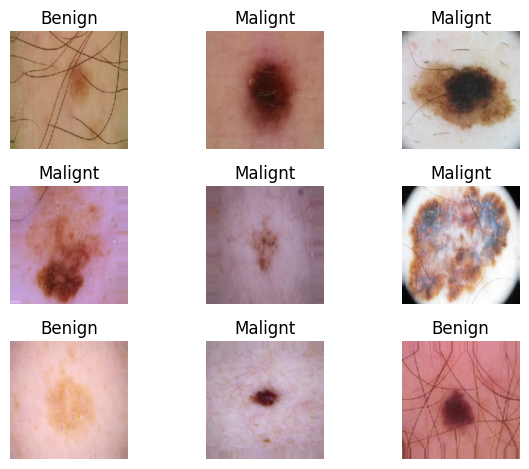

In [56]:
# hämta en batch från generatorn
images, labels = next(train_generator) # hämtar en batch med bilder och etiketter

# visa 9 exempelbilder
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])  
    label = "Malignt" if labels[i] == 1 else "Benign"
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice("filters_layer_0", [32, 64, 128]),
        kernel_size=(3, 3),
        activation="relu",
        input_shape=(224, 224, 3)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    for i in range(1, hp.Int("number_of_conv_layers", 2, 4)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Choice(f"filters_layer_{i}", [32, 64, 128]),
            kernel_size=(3, 3),
            activation="relu"
        ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(
        units=hp.Int("dense_units", 64, 256, step=64),
        activation="relu"
    ))
    model.add(tf.keras.layers.Dropout(
        rate=hp.Float("dropout_rate", 0.2, 0.5, step=0.1)
    ))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]

    )
    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max")
    max_epochs=50,
    factor=3,
    directory=TUNER_DIR,
    project_name=PROJECT_NAME,
    overwrite=OVERWRITE,
)


In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)


Trial 90 Complete [00h 32m 47s]
val_auc: 0.9730422496795654

Best val_auc So Far: 0.9756606817245483
Total elapsed time: 13h 27m 26s


In [ ]:
from tensorflow import keras
from tensorflow.keras import callbacks
from pathlib import Path

def save_model(model, filename, directory="exported_models"):
    out = Path(directory); out.mkdir(parents=True, exist_ok=True)
    path = out / filename
    model.save(path); print(f"Saved: {path}")
    return path

best_model = tuner.get_best_models(num_models=1)[0]

# sänk LR inför finetune
try:
    if hasattr(best_model.optimizer, "learning_rate"):
        keras.backend.set_value(best_model.optimizer.learning_rate, 2e-5)
except Exception:
    pass

MONITOR = "val_auc"
cb = [
    callbacks.ModelCheckpoint(
        filepath="exported_models/best_finetuned.keras",
        monitor=MONITOR, mode="max", save_best_only=True, save_weights_only=False
    ),
    callbacks.ReduceLROnPlateau(
        monitor=MONITOR, mode="max", factor=0.5, patience=4, min_lr=1e-7, verbose=1
    ),
    callbacks.EarlyStopping(
        monitor=MONITOR, mode="max", patience=10, restore_best_weights=True, verbose=1
    ),
]

history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=cb,
    verbose=1,
)

save_model(best_model, "keras_tuner_best_finetuned.h5")
save_model(best_model, "keras_tuner_best_finetuned.keras")


Epoch 1/200
241/241 [==============================] - 84s 346ms/step - loss: 0.2352 - accuracy: 0.9029 - auc: 0.9662 - val_loss: 0.2047 - val_accuracy: 0.9157 - val_auc: 0.9750 - lr: 2.0000e-05
Epoch 2/200
241/241 [==============================] - 83s 343ms/step - loss: 0.2331 - accuracy: 0.9030 - auc: 0.9664 - val_loss: 0.1962 - val_accuracy: 0.9204 - val_auc: 0.9773 - lr: 2.0000e-05
Epoch 3/200
241/241 [==============================] - 83s 342ms/step - loss: 0.2321 - accuracy: 0.9004 - auc: 0.9667 - val_loss: 0.2018 - val_accuracy: 0.9178 - val_auc: 0.9763 - lr: 2.0000e-05
Epoch 4/200
241/241 [==============================] - 82s 341ms/step - loss: 0.2296 - accuracy: 0.9034 - auc: 0.9673 - val_loss: 0.2044 - val_accuracy: 0.9141 - val_auc: 0.9752 - lr: 2.0000e-05
Epoch 5/200
241/241 [==============================] - 83s 344ms/step - loss: 0.2285 - accuracy: 0.9055 - auc: 0.9677 - val_loss: 0.2012 - val_accuracy: 0.9162 - val_auc: 0.9760 - lr: 2.0000e-05
Epoch 6/200
241/241 [====

WindowsPath('exported_models/keras_tuner_best_finetuned.keras')

In [ ]:
# === Optimize threshold on VAL, evaluate TEST, and save threshold to JSON ===
import numpy as np, json
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from pathlib import Path

def _get_true_prob(gen, model):
    y_true = gen.classes.astype(int)
    y_prob = model.predict(gen, verbose=0).ravel()
    return y_true, y_prob

# 1) Optimize threshold on VAL
vy_true, vy_prob = _get_true_prob(validation_generator, best_model)
vfpr, vtpr, vthr = roc_curve(vy_true, vy_prob)
best_idx = int(np.argmax(vtpr - vfpr))       # Youden J
best_thr = float(vthr[best_idx])
v_auc = roc_auc_score(vy_true, vy_prob)
print(f"[VAL]  AUC = {v_auc:.4f} | Best thr = {best_thr:.3f}")



# 3) Save threshold + class_indices for Streamlit
thr_info = {
    "best_threshold": best_thr,
    "class_indices": test_generator.class_indices if 'test_generator' in globals() else validation_generator.class_indices
}
Path("exported_models").mkdir(parents=True, exist_ok=True)
with open("exported_models/threshold.json", "w") as f:
    json.dump(thr_info, f)
print("\nSaved threshold and class indices to 'exported_models/threshold.json'")


[VAL]  AUC = 0.5004
[VAL]  Best threshold (Youden J) = 0.540
[TEST] AUC = 0.7797  (using VAL threshold 0.540)

Classification report (TEST):
              precision    recall  f1-score   support

      benign       0.89      0.37      0.53       500
   malignant       0.60      0.95      0.74       500

    accuracy                           0.66      1000
   macro avg       0.75      0.66      0.63      1000
weighted avg       0.75      0.66      0.63      1000

Confusion matrix (TEST):
[[187 313]
 [ 23 477]]


In [ ]:
import json

with open("exported_models/threshold.json") as f:
    print(json.load(f))


In [66]:
# 1) Kolla class-indices (ordning)
print("Train:", train_generator.class_indices)
print("Val:", validation_generator.class_indices)
print("Test:", test_generator.class_indices)

# 2) Kolla preprocessing: tar en bild från val och visar min/max
x, y = next(iter(validation_generator))
print("Val-bild pixel-range:", x.min(), x.max(), "Label:", y[:10])

# 3) Kolla att rätt modell laddas
print("Modell layers:", len(model.layers))
print("Första 5 lagren:", [l.name for l in model.layers[:5]])


Train: {'benign': 0, 'malignant': 1}
Val: {'benign': 0, 'malignant': 1}
Test: {'benign': 0, 'malignant': 1}
Val-bild pixel-range: 0.0 1.0 Label: [1. 1. 1. 1. 0. 1. 0. 1. 0. 0.]
Modell layers: 11
Första 5 lagren: ['input_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'max_pooling2d_4']


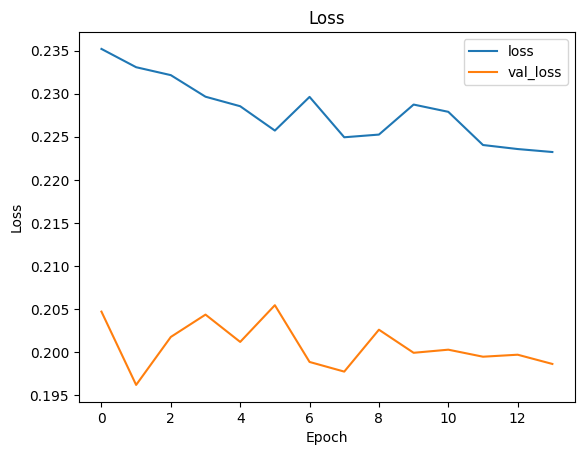

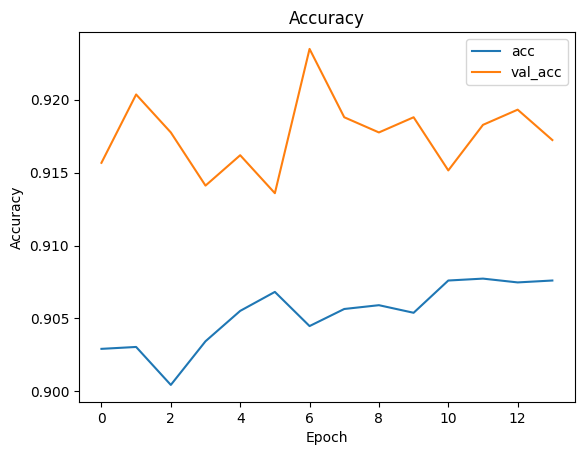

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")

plt.figure()
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.show()


In [62]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images1/test',               # mappen för testbilderna
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False                # viktigt! för rätt ordning
)


Found 1000 images belonging to 2 classes.


class_indices: {'benign': 0, 'malignant': 1}
1000 1000
              precision    recall  f1-score   support

      benign       0.89      0.32      0.47       500
   malignant       0.59      0.96      0.73       500

    accuracy                           0.64      1000
   macro avg       0.74      0.64      0.60      1000
weighted avg       0.74      0.64      0.60      1000

[[161 339]
 [ 19 481]]
AUC: 0.779692


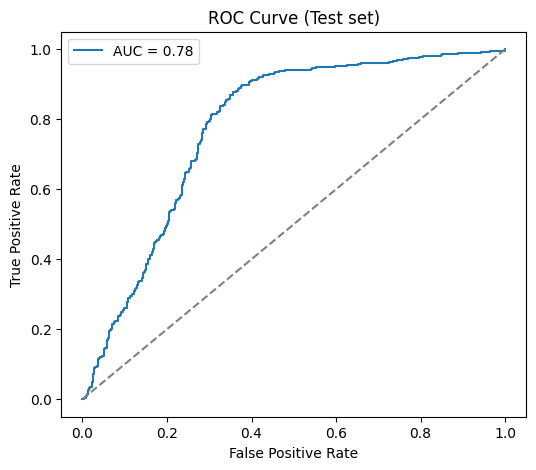

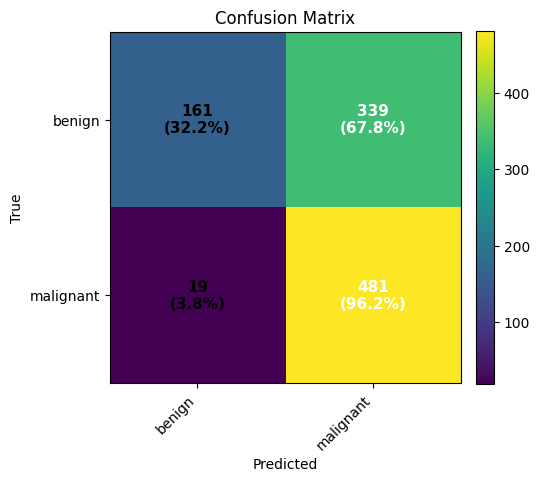

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# IMPORTANT: your test/val generators must be created with shuffle=False
# test_generator = test_datagen.flow_from_directory(..., class_mode='binary', shuffle=False)

gen = test_generator  # <-- use ONE generator consistently (or switch to validation_generator)

# Check mapping and pick positive label
print("class_indices:", gen.class_indices)  # e.g. {'benign': 0, 'malignant': 1}
pos_label = gen.class_indices.get('malignant', 1)

# Predict probabilities (no threshold), aligned order
gen.reset()
y_pred_prob = model.predict(gen, verbose=0).ravel()
y_true = gen.classes

print(len(y_pred_prob), len(y_true))  # should match

# Classification report at 0.5 threshold (or choose another later)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred, target_names=list(gen.class_indices.keys())))

# Confusion matrix (optional)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# ROC + AUC on the SAME split
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob, pos_label=pos_label)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test set)")
plt.legend()
plt.show()


# Använd EN generator konsekvent (test eller val) och se till att den skapats med shuffle=False
gen = test_generator  # eller validation_generator
try:
    assert getattr(gen, "shuffle", False) is False
except AssertionError:
    raise ValueError("Generator måste skapas med shuffle=False för att y_true ska aligna med prediktioner.")



# Prediktioner
gen.reset()
preds = model.predict(gen, verbose=0)
y_true = gen.classes  # redan i samma ordning när shuffle=False

# Binärt eller multi-klass?
binary = (preds.ndim == 1) or (preds.shape[1] == 1)
if binary:
    y_prob = preds.ravel()
    THR = 0.50  # justera vid behov
    y_pred = (y_prob >= THR).astype(int)
else:
    y_prob = None
    y_pred = np.argmax(preds, axis=1)


# Plot: Confusion matrix med siffror (+ rad-%)
row_sums = cm.sum(axis=1, keepdims=True)
cm_row = cm.astype("float") / np.where(row_sums == 0, 1, row_sums)

fig, ax = plt.subplots(figsize=(5.5, 5.5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks); ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_row[i, j] * 100
        ax.text(j, i, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()



Found 1921 images belonging to 2 classes.


c:\Users\albin\anaconda3\envs\tensorflow-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


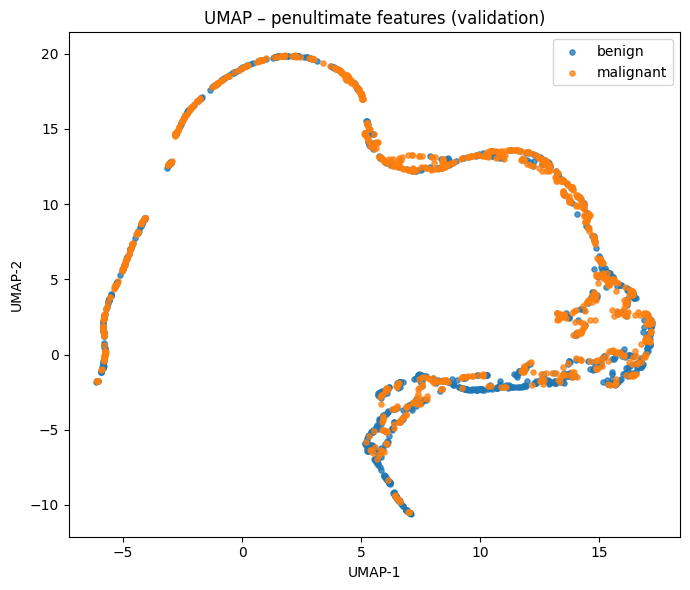

In [70]:
# === UMAP på din tränade modells näst sista lager (endast validation) ===
# Om saknas: pip install umap-learn
import umap.umap_ as umap
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Samma bildstorlek/split som du tränade med
IMG_SIZE = (224, 224)
VAL_SPLIT = 0.2
SEED = 42

# 1) Separat valideringsgenerator UTAN augmentation (rör inte din befintliga)
datagenerator_umap = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
validation_generator_umap = datagenerator_umap.flow_from_directory(
    'images1/train',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    subset='validation',
    shuffle=False,   # viktigt för att labels ska aligna
    seed=SEED
)

# 2) Bygg en "embed_model" som går genom alla lager utom sista (undvik model.input)
inp = tf.keras.Input(shape=IMG_SIZE + (3,))
x = inp
for lyr in model.layers[:-1]:
    # hoppa ev. InputLayer och kör i inferensläge för Dropout/BN
    if isinstance(lyr, tf.keras.layers.InputLayer):
        continue
    try:
        x = lyr(x, training=False)
    except TypeError:
        x = lyr(x)
embed_model = Model(inp, x, name="embed_from_penultimate")
embed_model.trainable = False

# 3) Hämta embeddings och kör UMAP
X = embed_model.predict(validation_generator_umap, verbose=0)  # features
y = validation_generator_umap.classes                           # 0/1 labels
names = {v: k for k, v in validation_generator_umap.class_indices.items()}

reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=SEED)
Z = reducer.fit_transform(X)

# 4) Plotta
plt.figure(figsize=(7,6))
for cls in np.unique(y):
    m = (y == cls)
    plt.scatter(Z[m, 0], Z[m, 1], s=14, alpha=0.75, label=names.get(cls, str(cls)))
plt.title("UMAP – penultimate features (validation)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.legend(); plt.tight_layout(); plt.show()


In [69]:
# === Quick-run utan träning: ladda modell, bygg val/test generators, räkna ut/spara tröskel ===
import json
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# 1) VÄLJ MODELLFIL
MODEL_PATH = "exported_models/keras_tuner_best_finetuned.h5"   # eller .keras

# 2) Ladda modellen
best_model = keras.models.load_model(MODEL_PATH, compile=False)
print("Loaded:", MODEL_PATH)

# 3) Hämta förväntad indata-storlek från modellen (t.ex. (None, 224, 224, 3))
H, W = best_model.input_shape[1], best_model.input_shape[2]
IMG_SIZE = (H, W)
BATCH = 32
SEED = 42
VAL_SPLIT = 0.20  # använd samma som i träningen

# 4) BYGG val/test generators som matchar TRÄNINGENS preprocessing
#    (Keras-tuner-CNN: bara rescale=1/255; ingen preprocess_input)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

# Validation tas från images1/train med subset='validation'
validation_generator = val_test_datagen.flow_from_directory(
    'images1/train',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Test (om mapp finns)
try:
    test_generator = val_test_datagen.flow_from_directory(
        'images1/test',
        target_size=IMG_SIZE,
        batch_size=BATCH,
        class_mode='binary',
        shuffle=False
    )
    HAS_TEST = True
except Exception:
    print("Ingen images1/test hittades – utvärderar på validation endast.")
    HAS_TEST = False

print("class_indices:", validation_generator.class_indices)  # {'benign':0, 'malignant':1} förväntas

# 5) Hjälpfunktion för sanningsvärden + sannolikheter
def _get_true_prob(gen, model):
    y_true = gen.classes.astype(int)
    y_prob = model.predict(gen, verbose=0).ravel()
    return y_true, y_prob

# 6) Optimera tröskel på VAL (Youden’s J)
vy_true, vy_prob = _get_true_prob(validation_generator, best_model)
vfpr, vtpr, vthr = roc_curve(vy_true, vy_prob)
best_idx = int(np.argmax(vtpr - vfpr))
best_thr = float(vthr[best_idx])
v_auc = roc_auc_score(vy_true, vy_prob)
print(f"[VAL]  AUC = {v_auc:.4f} | Best threshold (Youden J) = {best_thr:.3f}")

# 7) Utvärdera TEST med samma tröskel (om test finns)
if HAS_TEST:
    ty_true, ty_prob = _get_true_prob(test_generator, best_model)
    t_auc = roc_auc_score(ty_true, ty_prob)
    t_pred = (ty_prob >= best_thr).astype(int)
    print(f"[TEST] AUC = {t_auc:.4f} (using VAL thr {best_thr:.3f})")
    print("\nClassification report (TEST):")
    print(classification_report(ty_true, t_pred, target_names=list(test_generator.class_indices.keys())))
    print("Confusion matrix (TEST):")
    print(confusion_matrix(ty_true, t_pred))
else:
    v_pred = (vy_prob >= best_thr).astype(int)
    print("\nClassification report (VAL):")
    print(classification_report(vy_true, v_pred, target_names=list(validation_generator.class_indices.keys())))
    print("Confusion matrix (VAL):")
    print(confusion_matrix(vy_true, v_pred))

# 8) Spara tröskel + klassordning till JSON för Streamlit (kan användas senare)
thr_info = {
    "best_threshold": best_thr,
    "class_indices": validation_generator.class_indices,  # samma mapping
    "positive_class": 1
}
Path("exported_models").mkdir(parents=True, exist_ok=True)
with open("exported_models/threshold.json", "w") as f:
    json.dump(thr_info, f, indent=2)
print("\nSaved threshold to exported_models/threshold.json")


Loaded: exported_models/keras_tuner_best_finetuned.h5
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
class_indices: {'benign': 0, 'malignant': 1}
[VAL]  AUC = 0.9755 | Best threshold (Youden J) = 0.402
[TEST] AUC = 0.9684 (using VAL thr 0.402)

Classification report (TEST):
              precision    recall  f1-score   support

      benign       0.89      0.92      0.90       500
   malignant       0.91      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Confusion matrix (TEST):
[[458  42]
 [ 55 445]]

Saved threshold to exported_models/threshold.json


In [73]:
# === STATLESS EVAL: ladda modell, bygg rena generators, räkna ut tröskel, utvärdera, spara ===
import os, json, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from pathlib import Path

# 0) Parametrar
MODEL_PATH = "exported_models/keras_tuner_best_finetuned.h5"   # eller .keras
IMG_ROOT   = "images1"
VAL_SPLIT  = 0.20
BATCH      = 32
SEED       = 42

# 1) Rensa ev. tidigare state och ladda modell
tf.keras.backend.clear_session()
model = keras.models.load_model(MODEL_PATH, compile=False)
H, W = model.input_shape[1:3]
print(f"Loaded model: {MODEL_PATH}  |  input={H}x{W}")

# 2) Bygg **rena** generators (ingen augmentation i val/test, alltid shuffle=False)
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(IMG_ROOT, "train"),
    target_size=(H, W),
    batch_size=BATCH,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED,
)

# Test om du har images1/test; annars hoppar vi över
HAS_TEST = os.path.isdir(os.path.join(IMG_ROOT, "test"))
if HAS_TEST:
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(IMG_ROOT, "test"),
        target_size=(H, W),
        batch_size=BATCH,
        class_mode="binary",
        shuffle=False
    )

print("class_indices:", validation_generator.class_indices)

# 3) Sanity: säkra att val/test är rescale-only och shuffle=False
vd = validation_generator.image_data_generator
assert getattr(vd, "rescale", None) == 1./255, "Val rescale fel"
assert getattr(validation_generator, "shuffle", True) is False, "Val shuffle ska vara False"

# 4) Hjälpfunktion
def _get_true_prob(gen, mdl):
    y_true = gen.classes.astype(int)
    y_prob = mdl.predict(gen, verbose=0).ravel()
    return y_true, y_prob

# 5) Optimera tröskel på VAL (Youden J)
vy_true, vy_prob = _get_true_prob(validation_generator, model)
fpr, tpr, thr = roc_curve(vy_true, vy_prob)
best_thr = float(thr[(tpr - fpr).argmax()])
v_auc = roc_auc_score(vy_true, vy_prob)
print(f"[VAL]  AUC = {v_auc:.4f} | Best threshold = {best_thr:.3f}")

# 6) Utvärdera TEST med samma tröskel (om finns)
if HAS_TEST:
    ty_true, ty_prob = _get_true_prob(test_generator, model)
    t_auc = roc_auc_score(ty_true, ty_prob)
    t_pred = (ty_prob >= best_thr).astype(int)
    print(f"[TEST] AUC = {t_auc:.4f} (thr {best_thr:.3f})")
    print("\nClassification report (TEST):")
    print(classification_report(ty_true, t_pred, target_names=list(test_generator.class_indices.keys())))
    print("Confusion matrix (TEST):")
    print(confusion_matrix(ty_true, t_pred))
else:
    v_pred = (vy_prob >= best_thr).astype(int)
    print("\nClassification report (VAL):")
    print(classification_report(vy_true, v_pred, target_names=list(validation_generator.class_indices.keys())))
    print("Confusion matrix (VAL):")
    print(confusion_matrix(vy_true, v_pred))

# 7) Spara tröskeln för Streamlit (frivilligt men rekommenderat)
thr_info = {
    "best_threshold": best_thr,
    "class_indices": validation_generator.class_indices,
    "positive_class": 1,
}
Path("exported_models").mkdir(parents=True, exist_ok=True)
with open("exported_models/threshold.json", "w") as f:
    json.dump(thr_info, f, indent=2)
print("\nSaved threshold to exported_models/threshold.json")


Loaded model: exported_models/keras_tuner_best_finetuned.h5  |  input=224x224
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
class_indices: {'benign': 0, 'malignant': 1}
[VAL]  AUC = 0.9755 | Best threshold = 0.402
[TEST] AUC = 0.9684 (thr 0.402)

Classification report (TEST):
              precision    recall  f1-score   support

      benign       0.89      0.92      0.90       500
   malignant       0.91      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Confusion matrix (TEST):
[[458  42]
 [ 55 445]]

Saved threshold to exported_models/threshold.json


In [6]:
# === ROC + Confusion Matrix (med förklaring) + UMAP ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.models import Model

# ---------- helpers ----------
def get_true_prob(gen, mdl):
    y_true = gen.classes.astype(int)
    y_prob = mdl.predict(gen, verbose=0).ravel()
    return y_true, y_prob

def ensure_threshold(val_gen, mdl, existing_thr=None):
    """Return best_thr; if given, reuse; else compute Youden J on VAL."""
    if existing_thr is not None:
        return float(existing_thr)
    vy_true, vy_prob = get_true_prob(val_gen, mdl)
    fpr, tpr, thr = roc_curve(vy_true, vy_prob)
    return float(thr[(tpr - fpr).argmax()])

def plot_cm_with_summary_on_figure(y_true, y_pred, class_names, title="Confusion Matrix"):
    # 1) Classification report i konsolen
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 2) Summering av metrics i konsolen
    rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    acc  = rep["accuracy"]
    prec = np.mean([rep[c]["precision"] for c in class_names])
    rec  = np.mean([rep[c]["recall"]    for c in class_names])
    f1   = np.mean([rep[c]["f1-score"]  for c in class_names])

    print("\n--- Kort summering av metrics ---")
    print(f"Accuracy:  {acc:.2f}  → andel rätt av alla")
    print(f"Precision: {prec:.2f}  → andel av positiva prediktioner som stämmer")
    print(f"Recall:    {rec:.2f}  → andel av verkliga positiva som hittas")
    print(f"F1-score:  {f1:.2f}  → balans mellan precision och recall")

    # 3) Rita confusion matrix med förklarande text under figuren
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    im = plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)

    # Lägg till siffror i rutorna
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha="center", va="center", fontsize=11)

    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Text under bilden
    plt.figtext(
        0.5, -0.05,
        "Höga tal på diagonalen = många rätt. Låga tal utanför diagonalen = få fel.\n"
        "Denna confusion matrix visar att modellen förutsäger de flesta rätt.",
        ha="center", fontsize=10
    )

    plt.tight_layout()
    plt.show()
    return cm

# ---------- Setup ----------
class_names = list(validation_generator.class_indices.keys())
best_thr = None
thr_path = Path("exported_models/threshold.json")
if thr_path.exists():
    import json
    info = json.loads(thr_path.read_text())
    best_thr = float(info.get("best_threshold", 0.5))

best_thr = ensure_threshold(validation_generator, model, existing_thr=best_thr)
print(f"Using decision threshold: {best_thr:.3f}")

# ---------- 1) ROC (endast VAL) ----------
vy_true, vy_prob = get_true_prob(validation_generator, model)
vfpr, vtpr, _ = roc_curve(vy_true, vy_prob)
v_auc = roc_auc_score(vy_true, vy_prob)

plt.figure(figsize=(6,4))
plt.plot(vfpr, vtpr, label=f"AUC = {v_auc:.3f}")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.tight_layout()

# Förklarande text om just denna ROC
roc_text = (
    f"AUC = {v_auc:.3f} → Modellen skiljer klasserna väl.\n"
    "Att kurvan snabbt går mot övre vänstra hörnet betyder många rätt med få fel."
)
plt.figtext(0.5, -0.1, roc_text, ha="center", fontsize=10)
plt.show()

# ---------- 2) Confusion Matrix ----------
y_true = vy_true
y_pred = (vy_prob >= best_thr).astype(int)
cm = plot_cm_with_summary_on_figure(y_true, y_pred, class_names, title="Confusion Matrix (VAL)")

# ---------- 3) UMAP ----------
try:
    import umap.umap_ as umap
except Exception:
    raise RuntimeError("UMAP saknas. Installera med: pip install umap-learn")

feat_gen = validation_generator
feat_labels = feat_gen.classes

try:
    penultimate = model.layers[-2].output
except Exception as e:
    raise RuntimeError("Kunde inte hitta penultimate-lagret. Justera model.layers[-2].") from e

feature_model = Model(inputs=model.input, outputs=penultimate)
features = feature_model.predict(feat_gen, verbose=0)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    embedding[:,0], embedding[:,1],
    c=feat_labels, cmap="coolwarm", alpha=0.75, s=18, edgecolors="none"
)
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Class", loc="best")
plt.title(f"UMAP – penultimate features (VAL)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.figtext(0.5, -0.05, "Bra separering = modellen hittar tydliga mönster mellan klasser", ha="center")
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined